# This notebook was created to wrangle all of the insertion/deletion variants in the 31,428 isolates and store the allele frequencies for variants with an alternate allele frequency $\ge 10\%$

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy

####################################################################################################################################################################################

# [1] This section of the notebook loads all of the Lineage Calls that were made on the isolates in rollingDB as well as the mean coverage / isolates for all of the isolates in rollingDB. 

####################################################################################################################################################################################

#### We runs through the pilon-generated VCF for each isolate (N = 33,875) and scrapes the High Quality INDEL Variant calls made against H37Rv. The DataFrame containing these high quality INDEL calls (with the Reference Position, Reference Allele and Alterante Allele) for each isolate is then stored in a directory containing all of the DFs for all isolates. 

#### Side-Note: Some isolate have ~20x coverage and we require 20 reads at a given position to make an INDEL call

#### Scrape Luca's DB


In [5]:
## genomic data directory
rolling_DB_dir = '/n/data1/hms/dbmi/farhat/rollingDB/genomic_data/'

#get all folders (each folder corresponds to a different sequenced isolate)
isolate_directories = os.listdir(rolling_DB_dir)

#iterate through each sequenced isolate
isolate_i = 0

for isolate_ID in isolate_directories:

    #directory that stores files for each sequenced isolate
    directory_for_sequenced_isolate = rolling_DB_dir + isolate_ID

    #check to see if megapipe successfully ran on sequenced isolate
    try:
        #existence of a PILON and QUALIMAP directories and corresponding VCF file
        if ( 'pilon' in os.listdir(directory_for_sequenced_isolate) ):
            
            #existence of a REDUCED VCF and GENOME-QUALITY files and existence of FULL VCF file in relevent directories 
            if ( 'vcf' in list( itertools.chain.from_iterable( [filename.split('.') for filename in os.listdir(directory_for_sequenced_isolate + '/pilon/')] ) ) ) and ( isolate_ID + '_full' in list( itertools.chain.from_iterable( [filename.split('.') for filename in os.listdir(directory_for_sequenced_isolate + '/pilon/')] ) ) ):
                
                #we have a valid VCF file so megapipe ran successfully, let's keep the variant call information for this sequenced isolate
                
                #PILON-generated VCF DATA
                ########################################################################################################################
                
                #dictionaries to construct DataFrame from later that hold information about each high-quality SNP found for a specific isolate from rollingDB
                ref_dict = {} #reference allele
                alt_dict = {} #alternate allele
                
                #load in VCF file if one was found
                vcf_reader = vcf.Reader( open(directory_for_sequenced_isolate + '/pilon/' + isolate_ID + '.vcf' , 'r') )

                #iterate through each Variant Call 
                for record in vcf_reader:
                    
                    #check to see if the call is a PASS by Pilon (PASS by Pilon ; there's exactly 1 alternate allele ; call supports the alternate allele)
                    if (record.FILTER == []) and (len(record.ALT) == 1) and (record.ALT != [None]):
                        
                        ref_pos = int( record.POS )
                        ref_allele = str( record.REF )  #allele on H37Rv
                        alt_allele = str( record.ALT[0] ) #alternate allele supported by reads
                        
                        #check to see if variant is INDEL (either Refeference or Alternate Alleles are > 1 base but not both ; 1 allele is 1bp, the other allele is > 1bp)
                        if ( (len(ref_allele) > 1) or (len(alt_allele) > 1) ) and ( (len(ref_allele) == 1) or (len(alt_allele) == 1) ):
                        
                            #keep only INDELs <= 10bp long (1 allele is 1bp ; the other allele is <= 11bp)
                            if (len(ref_allele) <= 11) and (len(alt_allele) <= 11):
                                
                                #analyze only INDELs with Depth metrics (larger structural variants don't have this)
                                quality_metrics = record.INFO.keys()
                                if ('MQ' in quality_metrics) and ('DC' in quality_metrics) and ('IC' in quality_metrics) and ('TD' in quality_metrics) and ('DP' in quality_metrics):
                            
                                    ##### Retrieve Relevant information for filtering quality of Base Call #####
                                    # Mean Mapping Quality @ locus
                                    MQ = record.INFO['MQ']
                                    # Number of Reads w/ Deletion 
                                    DC = record.INFO['DC']
                                    # Number of Reads w/ Insertion
                                    IC = record.INFO['IC']
                                    # Depth of Valid Reads in Pileup
                                    VD = record.INFO['DP']
                                    # Total Depth in Pileup
                                    TD = record.INFO['TD']

                                    ### Filtering Criteria

                                    #---> Mean Mapping Quality > 30
                                    #---> Number of High Quality Reads >= 20
                                    if (MQ > 30) and (VD >= 20): #INDEL passed filtering criteria!

                                        # Calculate Alternate Allele Frequency
                                        ########################################################################

                                        #calculate INDEL (Alternate Allele) Frequency from Deletion/Insertion Count & Total Depth (all metrics include ALL reads)
                                        alt_allele_frequency = float(max(DC , IC)) / float(TD)

                                        ########################################################################

                                        # use INDEL calls that pass the following filters
                                        #---> alternate (INDEL) allele frequency >= 10%
                                        #---> Reads supporting INDEL variant >= 10 reads
                                        if (alt_allele_frequency >= 0.10) and (float(max(DC , IC)) >= 10):

                                            # Store good-quality SNV in SNV dictionaries
                                            ref_dict[ref_pos] = ref_allele
                                            alt_dict[ref_pos] = alt_allele

                #construct DataFrame from dictionaries
                INDEL_DF = pd.DataFrame( index = pd.Series( ref_dict.keys() ) )
                INDEL_DF['ref'] = pd.Series(ref_dict)
                INDEL_DF['alt'] = pd.Series(alt_dict)

                #make reference-position a column and re-index, sort according to reference position
                INDEL_DF['pos'] = INDEL_DF.index
                INDEL_DF.sort_values(by = 'pos' , ascending = True , inplace = True)
                INDEL_DF.reset_index(inplace = True , drop = True)

                #pickle DataFrame holding High Quality SNVs from isolate
                INDEL_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/all_HighQuality_INDELs_found_in_rollingDB/' + isolate_ID + '_INDELs.pkl')
                ########################################################################################################################
                
                #keep track of progress   
                isolate_i += 1
                if isolate_i % np.ceil(0.05*len(isolate_directories)) == 0:
                    print float(isolate_i) / float(len(isolate_directories))
        
    except OSError: #hit some file that is not another directory with genomic data 
        continue

0.0500152951973
0.100030590395
0.150045885592
0.200061180789
0.250076475987
0.300091771184
0.350107066381
0.400122361578
0.450137656776
0.500152951973
0.55016824717
0.600183542368
0.650198837565


####################################################################################################################################################################################

# [2]  The purpose of this section of the notebook is generate the master catalogue of (high-quality) INDEL calls made in rollingDB by iterating over all of the HQ SNV DataFrames for each isolate.

####################################################################################################################################################################################

In [3]:
import vcf
import os
import pandas as pd
import numpy as np
from pylab import MaxNLocator
import ast
import itertools
import time
import sys
import itertools
import gzip
import scipy

In [4]:
#list of pickles DataFrame files for INDELs for each isolate in rollingDB
INDEL_DF_list = os.listdir('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/all_HighQuality_INDELs_found_in_rollingDB')

In [5]:
def store_INDEL_info_from_INDEL(INDEL_DF_row):

    ref_allele , alt_allele , ref_pos = list(INDEL_DF_row)
    
    INDEL_i_key = ref_allele + '_' + str(ref_pos) + '_' + alt_allele

    #INDEL is not documented at this Reference Position
    if INDEL_i_key not in ref_pos_dict.keys():

        #store a new row for INDEL at this reference position; ref position, ref allele, alt allele 
        ref_pos_dict[INDEL_i_key] = ref_pos
        ref_allele_dict[INDEL_i_key] = ref_allele
        alt_allele_dict[INDEL_i_key] = alt_allele
        num_isolates_dict[INDEL_i_key] = 1

    #a INDEL is already documented at this Reference Position
    else:

        #increment # of isolates that have an indel here
        num_isolates_dict[INDEL_i_key] = num_isolates_dict[INDEL_i_key] + 1

In [6]:
#create dictionaries to store INDEL info for each isolate
ref_pos_dict = {}
ref_allele_dict = {}
alt_allele_dict = {}
num_isolates_dict = {}

#iterate through each sequenced isolate
isolate_i = 0

#iterate through all DataFrames for each isolate in rollingDB
for pickled_INDEL_DF in INDEL_DF_list:
    
    #load SNV DF for isolates from pickles object
    INDEL_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/all_HighQuality_INDELs_found_in_rollingDB/' + pickled_INDEL_DF)

    #extract important info from SNV df
    _ = INDEL_DF.apply(lambda row: store_INDEL_info_from_INDEL(row) , axis = 1 )  
    
    #keep track of progress   
    isolate_i += 1
    if isolate_i % np.ceil(0.05*len(INDEL_DF_list)) == 0:
        print float(isolate_i) / float(len(INDEL_DF_list))

0.0500056028687
0.100011205737
0.150016808606
0.200022411475
0.250028014343
0.300033617212
0.350039220081
0.400044822949
0.450050425818
0.500056028687
0.550061631555
0.600067234424
0.650072837293
0.700078440161
0.75008404303
0.800089645899
0.850095248767
0.900100851636
0.950106454505


In [7]:
#construct DataFrame from dictionaries
INDEL_DF = pd.DataFrame( index = pd.Series( ref_pos_dict.keys() ) )
INDEL_DF['indel_id'] = INDEL_DF.index
INDEL_DF['ref_pos'] = pd.Series(ref_pos_dict)
INDEL_DF['ref_allele'] = pd.Series(ref_allele_dict)
INDEL_DF['alt_allele'] = pd.Series(alt_allele_dict)
INDEL_DF['num_isolates'] = pd.Series(num_isolates_dict)

#sort according to reference position
INDEL_DF.sort_values(by = 'ref_pos' , ascending = True , inplace = True)

INDEL_DF.reset_index(inplace = True , drop = True)

In [8]:
INDEL_DF.head()

,indel_id,ref_pos,ref_allele,alt_allele,num_isolates
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,3
1,TC_1549_T,1549,TC,T,3
2,TAA_1552_T,1552,TAA,T,1
3,TA_1552_T,1552,TA,T,479
4,T_1552_TA,1552,T,TA,31


In [9]:
INDEL_DF.tail()

,indel_id,ref_pos,ref_allele,alt_allele,num_isolates
59502,C_4411205_CA,4411205,C,CA,1
59503,AG_4411208_A,4411208,AG,A,1
59504,C_4411423_CTG,4411423,C,CTG,3
59505,CCTG_4411459_C,4411459,CCTG,C,4
59506,AC_4411486_A,4411486,AC,A,1


In [10]:
np.shape(INDEL_DF)

(59507, 5)

#### Output Pickle files for downstream analysis

In [11]:
INDEL_DF.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/all_HighQuality_INDELs_found_in_rollingDB_catalogue/all_HighQuality_INDELs_found_in_rollingDB_catalogue.pkl' )

####################################################################################################################################################################################

# [3] The purpose of this section of the notebook is to analyze the catalogue of (high-quality) INDEL calls made in rollingDB. For population genetic analyses, we will retain only INDELs that are present in at least 1 isolate. We then construct a skeleton genotype DF (rows = Reference Position , columns = isolates) for all of the remaining INDELs.

####################################################################################################################################################################################

### Construct a series for the isolate annotation

In [12]:
HQ_INDEL_per_isolate_files = os.listdir('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/all_HighQuality_INDELs_found_in_rollingDB/')
isolate_ids_list = [isolate_id.split('_INDELs')[0] for isolate_id in HQ_INDEL_per_isolate_files]
isolate_id_series = pd.Series(isolate_ids_list)

In [13]:
isolate_id_series.head() #index = column indices of genotype matrix, values isolate IDs

0    SAMN13051687
1    SAMN09100245
2    SAMN08732238
3    SAMN07658260
4    SAMN03648003
dtype: object

In [14]:
np.shape(isolate_id_series)

(35696,)

#### Remove 2 bad isolates from isolate annotation

**Remove:** Delete ID for isolate **IDR1400002533** since Full GZipped VCF looks corrupt and remove from list accordingly!

In [15]:
isolate_id_series = isolate_id_series[isolate_id_series != 'IDR1400002533']

**Remove:** Delete ID for **Peru4994** since F2 calculations keeps failing for this isolate (lineage-defining SNP depths df is empty) **Think this is because sample has very low coverage**

In [16]:
isolate_id_series = isolate_id_series[isolate_id_series != 'Peru4994']

In [17]:
isolate_id_series.reset_index(inplace = True, drop = True)

In [18]:
isolate_id_series.head()

0    SAMN13051687
1    SAMN09100245
2    SAMN08732238
3    SAMN07658260
4    SAMN03648003
dtype: object

In [19]:
len(isolate_id_series)

35694

In [20]:
isolate_id_series.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/genotypes_isolate_annotation.pkl' )

### Load in catologue of INDELs detected within rollingDB

In [21]:
#INDEL data for all isoaltes in rollingDB 
INDEL_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/all_HighQuality_INDELs_found_in_rollingDB_catalogue/all_HighQuality_INDELs_found_in_rollingDB_catalogue.pkl')

In [22]:
INDEL_DF.head()

,indel_id,ref_pos,ref_allele,alt_allele,num_isolates
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,3
1,TC_1549_T,1549,TC,T,3
2,TAA_1552_T,1552,TAA,T,1
3,TA_1552_T,1552,TA,T,479
4,T_1552_TA,1552,T,TA,31


In [23]:
np.shape(INDEL_DF)

(59507, 5)

In [24]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

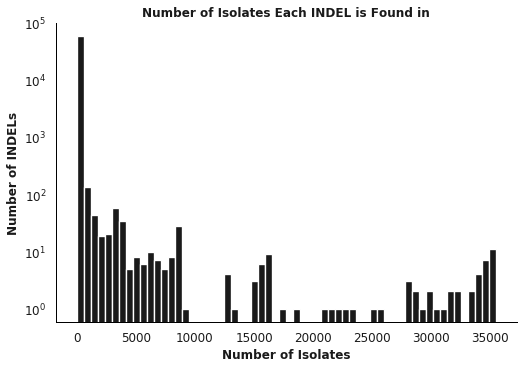

In [25]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(INDEL_DF.num_isolates.astype(float) , bins = 60 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.35)

plt.title('Number of Isolates Each INDEL is Found in', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Number of Isolates', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of INDELs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Re-Structure DataFrame to include the INDEL id, Reference Position, Reference Allele and Alternate Allele(s)

In [26]:
INDEL_annotation_DF = pd.DataFrame(index = range( 0 , np.shape(INDEL_DF)[0] ) ) #index for each INDEL
INDEL_annotation_DF['key'] = list(INDEL_DF.indel_id) #key for corresponding INDEL
INDEL_annotation_DF['pos'] = list(INDEL_DF.ref_pos) #H37Rv Reference Position
INDEL_annotation_DF['ref'] = list(INDEL_DF.ref_allele) #reference allele
INDEL_annotation_DF['alt'] = list(INDEL_DF.alt_allele) #alterante allele

In [27]:
np.shape(INDEL_annotation_DF)

(59507, 4)

#### This is the DataFrame which we'll use to extract INDELs of interest when iterating over all of the VCF files in rollingDB

In [28]:
INDEL_annotation_DF.head() #index = row indices of genotype matrix , 0 supports ref, 1 supports alt

,key,pos,ref,alt
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A
1,TC_1549_T,1549,TC,T
2,TAA_1552_T,1552,TAA,T
3,TA_1552_T,1552,TA,T
4,T_1552_TA,1552,T,TA


In [29]:
INDEL_annotation_DF.tail()

,key,pos,ref,alt
59502,C_4411205_CA,4411205,C,CA
59503,AG_4411208_A,4411208,AG,A
59504,C_4411423_CTG,4411423,C,CTG
59505,CCTG_4411459_C,4411459,CCTG,C
59506,AC_4411486_A,4411486,AC,A


Output Annotation for SNVs of interest in Genotypes folder

In [30]:
INDEL_annotation_DF.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/genotypes_INDEL_annotation.pkl' )

#### Create a text file with a single column of all Reference Positions that we're interested in based off of DF above. We will use this text file to subset the *full* VCF files to only the positions that Reference Positions that have an INDEL in at least 1 isolate.

Get number of unique Reference Positions (with at least 1 INDEL)

In [31]:
unique_ref_pos_with_indels = list( np.sort( list( set( INDEL_annotation_DF.pos ) ) ) )
unique_ref_pos_with_indels = [str(ref_pos) for ref_pos in unique_ref_pos_with_indels]

In [32]:
len(unique_ref_pos_with_indels)

56184

In [33]:
unique_ref_pos_with_indels[:5]

['313', '1549', '1552', '1560', '1561']

In [34]:
unique_ref_pos_with_indels[-5:]

['4411205', '4411208', '4411423', '4411459', '4411486']

In [35]:
INDEL_ref_positions = ['NC_000962.3\t' + ref_pos for ref_pos in unique_ref_pos_with_indels ]

#save each element as a new row in a text file
with open('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/ref_positions_to_select.txt', 'w') as f:
    for item in INDEL_ref_positions:
        f.write("%s\n" % item)

####################################################################################################################################################################################

# [4] This section of the notebook prepares the script that iterates over all of the VCF files in rollingDB and outputs a genotype vector.

####################################################################################################################################################################################

In [37]:
import vcf
import os
import pandas as pd
import numpy as np

In [38]:
isolate_ID = 'Peru4988' #INPUT - isolate ID

#### Load INDEL-Index annotation (for indexing genotypes)

In [39]:
INDEL_annotation_DF = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/genotypes_INDEL_annotation.pkl' )

In [40]:
INDEL_annotation_DF.head()

,key,pos,ref,alt
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A
1,TC_1549_T,1549,TC,T
2,TAA_1552_T,1552,TAA,T
3,TA_1552_T,1552,TA,T
4,T_1552_TA,1552,T,TA


#### Convert INDEL annotation into dictionaries with keys = ROW indices of genotype array

In [42]:
#keys: INDEL identifier , values: Genotype Row Index
INDEL_dict = dict( zip( list(INDEL_annotation_DF.key) , list(INDEL_annotation_DF.index) ) )

#### Create set of H37Rv Reference Positions that are INDEL sites

In [43]:
H37Rv_ref_positions_of_interest = set(INDEL_annotation_DF.pos)

#### Construct 'skeleton' Numpy Array that will store the supported base for all INDELs of interest for a single isolate in rollingDB

- **0** INDEL not called in isolate (but good quality call otherwise)
- **10 - 100** INDEL called in isolate (Reference & Alternate Alleles match), % alternate allele frequency if >= 10%
- **-9** for Bad Quality calls

#### In constructing the Genotype Vector, we're going to iterate through all Reference Positions of interest and find the supported variant call from the VCF file for each position, assume bad quality Base Call/Missing Data unless evidence from VCF file supports a high-quality variant call

In [44]:
#number of INDELs we're interested in (where High Quality INDEL calls were made)
number_of_INDELs = len(INDEL_dict.keys())

In [45]:
number_of_INDELs

59507

In [46]:
#create an empty numpy array to store genotypes
genotypes_array = np.full(number_of_INDELs , -9 , dtype = int)

In [47]:
genotypes_array

array([-9, -9, -9, ..., -9, -9, -9])

In [48]:
np.shape(genotypes_array)

(59507,)

### Iterate through the subset VCF file corresponding to the isolate in rollingDB and fill in genotypes vector

In [49]:
#genomic data directory
VCF_genotypes_dir = '/n/data1/hms/dbmi/farhat/rollingDB/genomic_data/'

#directory that stores files for each sequenced isolate
directory_for_sequenced_isolate = VCF_genotypes_dir + isolate_ID + '/pilon/'

#load in VCF file if one was found
vcf_reader = vcf.Reader( open(directory_for_sequenced_isolate  + isolate_ID + '_full.vcf.gz' , 'r') )
    
#iterate through each Variant Call 
for record in vcf_reader:
    
    #check to see if H37Rv Reference Position is one of the INDEL sites of interest
    if record.POS in H37Rv_ref_positions_of_interest:

        ref_pos = int( record.POS )
        ref_allele = str( record.REF )  #allele on H37Rv
        alt_allele = str( record.ALT[0] ) #alternate allele supported by reads
        quality_metrics = record.INFO.keys()
        variant_i_key = ref_allele + '_' + str(ref_pos) + '_' + alt_allele #variant key, unique identifier for a specific variant

        #get the all relevant INDEL keys for possible INDELs @ this reference position
        INDEL_keys_at_ref_pos = list( INDEL_annotation_DF[INDEL_annotation_DF.pos == ref_pos].key )

         #BOOLEAN for whether INDEL was found
        INDEL_FOUND = False

        ###################################################################################################
        #The variant call at this reference position was high quality and was an INDEL of interest
        ###################################################################################################
        #check to see if the call is a PASS by Pilon (PASS by Pilon ; there's exactly 1 alternate allele ; call supports the alternate allele)
        if (record.FILTER == []) and (len(record.ALT) == 1) and (record.ALT != [None]):

            #check to see if variant is INDEL (either Refeference or Alternate Alleles are > 1 base but not both ; 1 allele is 1bp, the other allele is > 1bp)
            if ( (len(ref_allele) > 1) or (len(alt_allele) > 1) ) and ( (len(ref_allele) == 1) or (len(alt_allele) == 1) ):

                #keep only INDELs <= 10bp long (1 allele is 1bp ; the other allele is <= 11bp)
                if (len(ref_allele) <= 11) and (len(alt_allele) <= 11):

                    #analyze only INDELs with Depth metrics (larger structural variants don't have this)
                    if ('MQ' in quality_metrics) and ('DC' in quality_metrics) and ('IC' in quality_metrics) and ('TD' in quality_metrics) and ('DP' in quality_metrics):

                        ##### Retrieve Relevant information for filtering quality of Base Call #####
                        # Mean Mapping Quality @ locus
                        MQ = record.INFO['MQ']
                        # Number of Reads w/ Deletion 
                        DC = record.INFO['DC']
                        # Number of Reads w/ Insertion
                        IC = record.INFO['IC']
                        # Depth of Valid Reads in Pileup
                        VD = record.INFO['DP']
                        # Total Depth in Pileup
                        TD = record.INFO['TD']

                        ### Filtering Criteria

                        #---> Mean Mapping Quality > 30
                        #---> Number of High Quality Reads >= 20
                        if (MQ > 30) and (VD >= 20): #INDEL passed filtering criteria!
                            
                            # Calculate Alternate Allele Frequency
                            ########################################################################

                            #calculate INDEL (Alternate Allele) Frequency from Deletion/Insertion Count & Total Depth (all metrics include ALL reads)
                            alt_allele_frequency = float(max(DC , IC)) / float(TD)

                            ########################################################################

                            # use INDEL calls that pass the following filters
                            #---> alternate (INDEL) allele frequency >= 10%
                            #---> Reads supporting INDEL variant >= 10 reads
                            if (alt_allele_frequency >= 0.10) and (float(max(DC , IC)) >= 10):

                                #INDEL passed filters, find relevant INDEL index and store '1' and store '0' in for all other possible INDELs at this reference position
                                if variant_i_key in INDEL_dict.keys():

                                    #BOOLEAN for whether INDEL was found
                                    INDEL_FOUND = True

                                    #store a '10' - '100' in Genotype Vector (INDEL index) referencing that the INDEL is supported in this isolate and alt AF >= 10%
                                    genotypes_array[INDEL_dict[variant_i_key]] = int(alt_allele_frequency * 100)

                                    #store a '0' in Genotype Vector (INDEL index) for all other INDELs @ this reference position (if there were multiple indels here)
                                    INDELs_not_detected = INDEL_keys_at_ref_pos.remove(variant_i_key)

                                    #if list of not empty, then there are some INDEL @ this ref pos that were not detected in this isolate
                                    if INDELs_not_detected != None: 

                                        for INDEL_i_key in INDELs_not_detected:

                                            genotypes_array[INDEL_dict[INDEL_i_key]] = 0

        ###################################################################################################
        #The variant call at this reference position was high quality but was not an INDEL of interest
        ###################################################################################################
        if (INDEL_FOUND == False) and (record.FILTER == []) and ('MQ' in quality_metrics) and ('DP' in quality_metrics):

            ##### Retrieve Relevant information for filtering quality of Base Call #####
            # Mean Mapping Quality @ locus
            MQ = record.INFO['MQ']
            # Depth of Valid Reads in Pileup
            VD = record.INFO['DP']

            ### Filtering Criteria

            #---> Mean Mapping Quality > 30
            #---> Number of High Quality Reads >= 20
            if (MQ > 30) and (VD >= 20): #variant passed filtering criteria!

                #store a '0' in Genotype Vector (INDEL index) for all INDELs @ this reference position
                for INDEL_i_key in INDEL_keys_at_ref_pos:

                    genotypes_array[INDEL_dict[INDEL_i_key]] = 0

Pickle Genotypes Array for downstream analysis

In [63]:
genotypes_array

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.save('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/Genotypes_per_isolate/' + isolate_ID + '/' + isolate_ID + '_genotypes' , genotypes_array , allow_pickle = True)

####################################################################################################################################################################################

# [5] This section of the notebook launches the script that was created in the previous section of the notebook and submits jobs for batches of isolates to make genotypes arrays for each isolate.

####################################################################################################################################################################################

In [3]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np
import itertools
import shutil

Every isolate in the pool of **35,694** isolates in rollingDB had a reduced VCF file and a corresponding Full VCF file. We will iterate through each of these Full VCF files and extract the base calls for only the **56,184** reference positions that we're interested in.

In [4]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/genotypes_isolate_annotation.pkl' )

In [5]:
isolate_id_series.head()

0    SAMN13051687
1    SAMN09100245
2    SAMN08732238
3    SAMN07658260
4    SAMN03648003
dtype: object

In [6]:
len(isolate_id_series)

35694

#### Create directory for each isolate to store output for genotyping (only run this once)

In [68]:
'''
for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/Genotypes_per_isolate/' + tag
    if os.path.exists(isolate_genotype_dir):
        shutil.rmtree(isolate_genotype_dir)
        os.makedirs(isolate_genotype_dir)
    elif not os.path.exists(isolate_genotype_dir):
        os.makedirs(isolate_genotype_dir)
'''

__Check Progress of Jobs:__ Isolates that need to have Full VCF >> Genotypes Array Reference Positions of Interest

In [7]:
isolate_ids_to_run_VCF_extraction = []
isolate_ids_completed = []

for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/Genotypes_per_isolate/' + tag
    
    #genotypes array file
    genotypes_array_path = isolate_genotype_dir + '/' + tag + '_genotypes.npy'
    
    #check for the existence of a genotypes file, if TRUE job has either started or completed
    if os.path.exists(genotypes_array_path):
            
        isolate_ids_completed.append(tag)
            
    #genotypes file doesn't exist, task never started
    else:
        
        isolate_ids_to_run_VCF_extraction.append(tag)

In [8]:
len(isolate_ids_completed)

35370

In [9]:
len(isolate_ids_to_run_VCF_extraction)

324

#### Construct genotypes array for reference positions of interest for isolates that had Full VCF files 

In [10]:
isolate_id_series = pd.Series(isolate_ids_to_run_VCF_extraction)

#### Extract genotypes for each isolate from VCF file containing a subset of Reference Positions from the Full VCF files

Create BASH scripts to extract genotypes of N isolates per job

In [11]:
N_isolates_per_job = 120

njobs = int( np.ceil( float( len( isolate_id_series ) ) / float(N_isolates_per_job) ) ) #number of jobs required if we split for every N isolates

In [12]:
print njobs

33


In [13]:
bash_scripts = []

#split jobs up into tasks of N
for first_isolate_i_for_job in np.arange(0 , (njobs)*N_isolates_per_job , N_isolates_per_job):

    last_isolate_i_for_job = first_isolate_i_for_job + N_isolates_per_job
    
    commands_list = []

    for isolate_i in range(first_isolate_i_for_job , last_isolate_i_for_job): 

        try:
            tag = isolate_id_series[isolate_i]

            commands_list.append( 'python /home/rv76/Farhat_Lab/Python_Scripts/homoplasy_project/mmpR_BDQ_mutant_project/rollingDB_extract_HQ_mixed_INDEL_genotypes.py {}'.format(tag) )
            
        except KeyError: #applies only to the last job if it has < N isolates
            continue
        
    bash_scripts.append(commands_list)

#### Submit each job to O2

In [14]:
job_num = 1
for job_i_commands_list in bash_scripts:
    
    #append all commands in a single string to be submitted as a job
    genotypes_extract_job = ''
    for command_i in job_i_commands_list:
        genotypes_extract_job  = genotypes_extract_job  + '\n' + command_i
    
    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/O2_SLURM_logs/make_genotypes_arrays_from_VCF/')

    job_name = 'Geno' + str(job_num)

    s = Slurm(job_name , {'partition':'short' , 'N':'1' , 't':'0-12:00:00' , 'mem':'2G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(genotypes_extract_job)

    print job_name  + ' : ' +  str(job_id)
    job_num += 1

submitted: Submitted batch job 18704688


Geno1 : 18704688


submitted: Submitted batch job 18704689
submitted: Submitted batch job 18704690
submitted: Submitted batch job 18704691


Geno2 : 18704689
Geno3 : 18704690
Geno4 : 18704691


submitted: Submitted batch job 18704692
submitted: Submitted batch job 18704693


Geno5 : 18704692
Geno6 : 18704693


submitted: Submitted batch job 18704694
submitted: Submitted batch job 18704695


Geno7 : 18704694
Geno8 : 18704695


submitted: Submitted batch job 18704696
submitted: Submitted batch job 18704697
submitted: Submitted batch job 18704698


Geno9 : 18704696
Geno10 : 18704697
Geno11 : 18704698


submitted: Submitted batch job 18704699


Geno12 : 18704699


submitted: Submitted batch job 18704700
submitted: Submitted batch job 18704701
submitted: Submitted batch job 18704702


Geno13 : 18704700
Geno14 : 18704701
Geno15 : 18704702


submitted: Submitted batch job 18704703
submitted: Submitted batch job 18704704
submitted: Submitted batch job 18704705


Geno16 : 18704703
Geno17 : 18704704
Geno18 : 18704705


submitted: Submitted batch job 18704706
submitted: Submitted batch job 18704707
submitted: Submitted batch job 18704708


Geno19 : 18704706
Geno20 : 18704707
Geno21 : 18704708


submitted: Submitted batch job 18704709
submitted: Submitted batch job 18704710
submitted: Submitted batch job 18704711


Geno22 : 18704709
Geno23 : 18704710
Geno24 : 18704711


submitted: Submitted batch job 18704712
submitted: Submitted batch job 18704713
submitted: Submitted batch job 18704714


Geno25 : 18704712
Geno26 : 18704713
Geno27 : 18704714


submitted: Submitted batch job 18704715
submitted: Submitted batch job 18704716
submitted: Submitted batch job 18704717


Geno28 : 18704715
Geno29 : 18704716
Geno30 : 18704717


submitted: Submitted batch job 18704718
submitted: Submitted batch job 18704719


Geno31 : 18704718
Geno32 : 18704719
Geno33 : 18704720


submitted: Submitted batch job 18704720


####################################################################################################################################################################################

# [6] Inspect the distribution of missing values after Genotype Matrix is filled in and filter out INDELs (Reference Positions) where values are missing in many isolates

####################################################################################################################################################################################

In [15]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import pickle

### Make sure all isolates have a corresponding _genotypes_ array

In [16]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/genotypes_isolate_annotation.pkl' )

In [17]:
np.shape(isolate_id_series)

(35694,)

__Check for Genotypes Arrays:__ Get isolate IDs that have a corresponding genotypes array

In [18]:
isolate_ids_with_genotypes = []
isolate_ids_without_genotypes = []

for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/Genotypes_per_isolate/' + tag
    
    #genotypes_array
    genotypes_array_pickle_file = isolate_genotype_dir + '/' + tag + '_genotypes.npy'
    
    #check for the existence of a genotypes file for this isolate
    if os.path.exists(genotypes_array_pickle_file):
            
        isolate_ids_with_genotypes.append(tag)
            
    else:
        
        isolate_ids_without_genotypes.append(tag)

In [19]:
len(isolate_ids_with_genotypes)

35694

In [20]:
len(isolate_ids_without_genotypes)

0

In [21]:
del isolate_ids_with_genotypes #clear variable from memory

### Concatenate genotypes arrays into a genotypes matrix for all isolates in rollingDB

Store the __genotypes array__ for each isolate into a list

In [22]:
genotypes_directory = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/Genotypes_per_isolate/'
genotype_arrays_per_isolate_list = []

#iterate through the genotypes arrays for each isolate
isolate_i = 0
for isolate_ID in isolate_id_series:
    
    #load genotypes array
    genotypes_array = np.load(genotypes_directory + isolate_ID + '/' + isolate_ID + '_genotypes.npy')
    
    #convert genotypes array from dtype 'int64' to 'int8' to save lots of memory
    genotypes_array = genotypes_array.astype('int8')
    
    #store genotypes array for this isolate in a list with all other genotypes arrays
    genotype_arrays_per_isolate_list.append(genotypes_array)
    
    if isolate_i % 1000 == 0:
        print float(isolate_i) / float(len(isolate_id_series))
    isolate_i += 1

0.0
0.0280159130386
0.0560318260772
0.0840477391158
0.112063652154
0.140079565193
0.168095478232
0.19611139127
0.224127304309
0.252143217347
0.280159130386
0.308175043425
0.336190956463
0.364206869502
0.39222278254
0.420238695579
0.448254608618
0.476270521656
0.504286434695
0.532302347734
0.560318260772
0.588334173811
0.616350086849
0.644365999888
0.672381912927
0.700397825965
0.728413739004
0.756429652042
0.784445565081
0.81246147812
0.840477391158
0.868493304197
0.896509217235
0.924525130274
0.952541043313
0.980556956351


Stack genotype arrays for all isolates to create one __genotypes matrix__ for all isolates 

In [23]:
genotypes_matrix = np.stack(genotype_arrays_per_isolate_list , axis = -1)

In [24]:
np.shape(genotypes_matrix)

(59507, 35694)

In [25]:
genotypes_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [26]:
print("%d bytes" % (genotypes_matrix.size * genotypes_matrix.itemsize))

2124042858 bytes


Genotypes Matrix is ~2.12 GB large

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [27]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Load __INDEL annotation file__

In [28]:
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/genotypes_INDEL_annotation.pkl')

In [29]:
INDEL_annotation_DF.head()

,key,pos,ref,alt
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A
1,TC_1549_T,1549,TC,T
2,TAA_1552_T,1552,TAA,T
3,TA_1552_T,1552,TA,T
4,T_1552_TA,1552,T,TA


In [30]:
np.shape(INDEL_annotation_DF)

(59507, 4)

In [31]:
del genotype_arrays_per_isolate_list #clear variable from memory

## [6.1] Drop INDEL sites that *[1]* have low Empirical Base Pair Recall (EBPR) Scores, *[2]* are located in Mobile Genetic Element (MGE) regions or *[3]* are located in a region with overlapping genes

### (Filter 1)  *FILTER* out INDELs with low EBR scores

#### Load list of low EBR score Reference positions to Drop (IL mapping/variant calling: sites with empirical score < 0.90)

In [32]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/H37Rv_sites_with_low_EBR_to_drop.pkl', 'rb') as f:
    H37Rv_positions_to_drop = pickle.load(f)
    
#convert to set, faster to check
H37Rv_positions_to_drop = set(H37Rv_positions_to_drop)

#### Filter out sites with low EBR scores

Drop unique INDELs from the __GENOTYPE MATRIX__ and __INDEL ANNOTATION FILE__

In [33]:
#construct boolean filter
INDELs_to_keep_filter = []
for H37Rv_pos_i in INDEL_annotation_DF.pos:
    
    if H37Rv_pos_i not in H37Rv_positions_to_drop:
        
        INDELs_to_keep_filter.append(True)
        
    elif H37Rv_pos_i in H37Rv_positions_to_drop:
        
        INDELs_to_keep_filter.append(False)

In [34]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[INDELs_to_keep_filter , :]

#filter SNP annotation file
INDEL_annotation_DF = INDEL_annotation_DF[INDELs_to_keep_filter]
INDEL_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered INDEL annotation DF (so new index matches indexing of genotypes matrix rows)

In [35]:
len(INDELs_to_keep_filter) - sum(INDELs_to_keep_filter) #number of sites dropped by this filter

3246

In [36]:
np.shape(genotypes_matrix)

(56261, 35694)

In [37]:
INDEL_annotation_DF.head()

,key,pos,ref,alt
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A
1,TC_1549_T,1549,TC,T
2,TAA_1552_T,1552,TAA,T
3,TA_1552_T,1552,TA,T
4,T_1552_TA,1552,T,TA


In [38]:
np.shape(INDEL_annotation_DF) #Annotation for Rows of Genotypes Matrix

(56261, 4)

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [39]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Save __INDEL annotation file__ in case kernel crashes when filtering

In [40]:
INDEL_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_INDEL_annotation.pkl')

### (Filter 2) *FILTER* out INDELs in MGE regions

#### Collect list of MGE Reference Positions to Drop

In [43]:
#csv files with category for each gene
gene_categories_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv')

In [44]:
gene_categories_df.head()

,name,gene_id,Gene_Category
0,Rv0001,Rv0001,Essential
1,Rv0002,Rv0002,Non-Essential
2,Rv0003,Rv0003,Non-Essential
3,Rv0004,Rv0004,Non-Essential
4,Rv0005,Rv0005,Antibiotic Resistance


In [45]:
#reference genome annotation
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

Collect positions for **MGEs**

In [46]:
H37Rv_positions_MGE_genes = []

for gene_id in gene_categories_df[gene_categories_df.Gene_Category == 'Mobile Genetic Element'].gene_id:
    
    #get reference positions tht corresond to each gene
    gene_id_info = reference_genome_annotation.loc[gene_id, :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)
    
    #store all corresponding H37Rv Reference Positions to gene_id in list of reference positions to scan
    H37Rv_positions_MGE_genes.append([H37Rv_start+1 , H37Rv_end+1])

In [47]:
len(H37Rv_positions_MGE_genes)

108

#### FILTER out sites in MGE regions

In [48]:
#construct boolean filter
INDELs_to_keep_filter = []
for H37Rv_pos_i in INDEL_annotation_DF.pos:

    bad_pos_i = False

    for problem_region in H37Rv_positions_MGE_genes:

        if (H37Rv_pos_i > problem_region[0]) and (H37Rv_pos_i < problem_region[1]):
            bad_pos_i = True
            break

    if bad_pos_i == False:
        INDELs_to_keep_filter.append(True)
    else:
        INDELs_to_keep_filter.append(False)

In [49]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[INDELs_to_keep_filter , :]

#filter INDEL annotation file
INDEL_annotation_DF = INDEL_annotation_DF[INDELs_to_keep_filter]
INDEL_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered INDEL annotation DF (so new index matches indexing of genotypes matrix rows)

In [50]:
len(INDELs_to_keep_filter) - sum(INDELs_to_keep_filter) #number of sites dropped by this filter

762

In [51]:
np.shape(genotypes_matrix)

(55499, 35694)

In [52]:
INDEL_annotation_DF.head()

,key,pos,ref,alt
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A
1,TC_1549_T,1549,TC,T
2,TAA_1552_T,1552,TAA,T
3,TA_1552_T,1552,TA,T
4,T_1552_TA,1552,T,TA


In [53]:
np.shape(INDEL_annotation_DF) #Annotation for Rows of Genotypes Matrix

(55499, 4)

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [54]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Save __INDEL annotation file__ in case kernel crashes when filtering

In [55]:
INDEL_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_INDEL_annotation.pkl')

### (Filter 3) *FILTER* out INDELs that located in H37Rv Reference Positions with overlapping genes

#### Load dictionary that contains the mapping between each H37Rv Reference Position and H37Rv locus tag, from the file: */n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt*

In [58]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)

In [59]:
ReferencePosition_Gene_mapping[1] #one gene mapped to position

['Rv0001']

In [60]:
ReferencePosition_Gene_mapping[2282101] #two genes mapped to position (overlapping)

['Rv2035', 'Rv2036']

In [61]:
ReferencePosition_Gene_mapping[2281250] #no genes mapped to position (intergenic)

[]

#### FILTER out sites that map to 2 (or more) H37Rv locus tags

In [62]:
INDELs_to_keep_filter = np.array( [(len(ReferencePosition_Gene_mapping[ref_pos_i]) < 2) for ref_pos_i in INDEL_annotation_DF.pos] )

In [63]:
sum(INDELs_to_keep_filter)

55268

In [64]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[INDELs_to_keep_filter , :]

#filter INDEL annotation file
INDEL_annotation_DF = INDEL_annotation_DF[INDELs_to_keep_filter]
INDEL_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered INDEL annotation DF (so new index matches indexing of genotypes matrix rows)

In [65]:
len(INDELs_to_keep_filter) - sum(INDELs_to_keep_filter) #number of sites dropped by this filter

231

In [66]:
np.shape(genotypes_matrix)

(55268, 35694)

In [67]:
INDEL_annotation_DF.head()

,key,pos,ref,alt
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A
1,TC_1549_T,1549,TC,T
2,TAA_1552_T,1552,TAA,T
3,TA_1552_T,1552,TA,T
4,T_1552_TA,1552,T,TA


In [68]:
np.shape(INDEL_annotation_DF) #Annotation for Rows of Genotypes Matrix

(55268, 4)

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [69]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Save __INDEL annotation file__ in case kernel crashes when filtering

In [70]:
INDEL_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_INDEL_annotation.pkl')

## [6.2] Drop low-quality isolates

### (Filter 4) *FILTER* to retain the same isolates that form the *SNPs* Genotypes Matrix

To keep things consistent with the SNP genotypes matrix, we will drop the isolates that were dropped as part of constructing the (**SNPs**) Genotypes Matrix in which SNPs were dropped that were poorly called in > 10% of isolates and Isolates were dropped with > 10% missing calls. These are also the isolates that were used in constructing the phylogenies.

In [71]:
isolate_annotation_df_from_SNP_analysis = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

In [72]:
isolate_annotation_df_from_SNP_analysis.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [73]:
np.shape(isolate_annotation_df_from_SNP_analysis)

(31428, 14)

In [74]:
np.shape(genotypes_matrix)

(55268, 35694)

Drop isolates from the __GENOTYPE MATRIX__ that were dropped in SNP genotypes analysis

In [75]:
len( np.array( [isolate_id in list(isolate_annotation_df_from_SNP_analysis.isolate_ID) for isolate_id in list(isolate_id_series)] ) )

35694

In [76]:
isolates_to_keep_filter = np.array( [isolate_id in list(isolate_annotation_df_from_SNP_analysis.isolate_ID) for isolate_id in list(isolate_id_series)] )

In [77]:
sum(isolates_to_keep_filter)

31428

In [78]:
genotypes_matrix = genotypes_matrix[: , isolates_to_keep_filter]

In [79]:
np.shape(genotypes_matrix) #Genotype Matrix

(55268, 31428)

Drop isolates with a high abundance of missing values from __ISOLATE ANNOTATION FILE__

In [80]:
isolate_annotation_series = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes/genotypes_isolate_annotation.pkl')

In [81]:
isolate_annotation_series.head()

0    SAMN13051687
1    SAMN09100245
2    SAMN08732238
3    SAMN07658260
4    SAMN03648003
dtype: object

In [82]:
np.shape(isolate_annotation_series) #Annotation for Columns of Genotypes Matrix

(35694,)

In [83]:
isolate_annotation_series = isolate_annotation_series[isolates_to_keep_filter]

#re-index new filtered isolate annotation series (so new index matches indexing of genotypes matrix columns)
isolate_annotation_series.reset_index(drop = True , inplace = True)

In [84]:
isolate_annotation_series.head()

0    SAMN13051687
1    SAMN09100245
2    SAMN08732238
3    SAMN07658260
4    SAMN03648003
dtype: object

In [85]:
np.shape(isolate_annotation_series) #Annotation for Columns of Genotypes Matrix

(31428,)

#### Save annotation files and genotypes matrix

In [86]:
#save isolate annotation file (columns of Genotype Matrix)
isolate_annotation_series.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_isolate_annotation.pkl')

#save SNP annotation file (rows of Genotype Matrix)
INDEL_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_INDEL_annotation.pkl')

#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

####################################################################################################################################################################################

# [7] Annotate INDELs w/ H37Rv Locus Info

####################################################################################################################################################################################

#### Retrieve information for H37Rv Reference Genome

In [87]:
####################################################################################################################################################################################
#load reference genome and reference annotation
reference_genome = '/home/rv76/Farhat_Lab/Reference_Seqs/H37Rv/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/home/rv76/Farhat_Lab/CSV_files/h37rv_genome_summary.txt', '\t').set_index('name')

####### Make a dictionary of all H37Rv reference positions and corresponding genes #######
ReferencePosition_Gene_mapping = {} #keys: H37Rv Reference Positions , values: gene_ids (may be multiple genes for some Reference Positions)

#store a list corresponding to every Reference Position (to store all genes that map to the Reference Position)
for H37Rv_RefPos in range(0 , len(reference_genome.seq) + 1):
    ReferencePosition_Gene_mapping[H37Rv_RefPos] = []

for gene_id_index in range(0 , len(reference_genome_annotation.index)):

    gene_id_info = reference_genome_annotation.ix[gene_id_index , :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)

    #store all corresponding H37Rv Reference Positions to gene_id in dictionary
    for H37Rv_RefPos in range(H37Rv_start+1 , H37Rv_end+1):

        ReferencePosition_Gene_mapping[H37Rv_RefPos].append(gene_id) #append gene_id to list already in dict
        
####################################################################################################################################################################################

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


#### Annotate INDELs

To annotate INDELs, we get gene_ids that the INDELs 'land in' and the gene-relative coordinate.

In [88]:
#load INDEL annotation file (rows of Genotype Matrix)
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_INDEL_annotation.pkl')

INDEL_annotation_DF.head()

,key,pos,ref,alt
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A
1,TC_1549_T,1549,TC,T
2,TAA_1552_T,1552,TAA,T
3,TA_1552_T,1552,TA,T
4,T_1552_TA,1552,T,TA


In [89]:
np.shape(INDEL_annotation_DF)

(55268, 4)

#### Gene Categories

In [90]:
#get Gene Categories
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')

#create dictionary, keys: H37Rv locus, values: gene category
gene_categories_map = dict( zip( list(gene_categories.gene_id) , list(gene_categories.Gene_Category) ) ) 

#### Gene Names

Parse through Mycobrowser (tuberculist) to collect gene names

In [91]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#retreive columns for locus tag & gene name
mycobrowser_table = mycobrowser_table.loc[: , ['Locus' , 'Name']]

#create dictionary, keys: H37Rv loucs, values: gene category
gene_names_map = dict( zip( list(mycobrowser_table.Locus) , list(mycobrowser_table.Name) ) ) 

#### Iterate through each INDEL to annotate

Some INDELs are present in more than 1 gene, have to account for this

In [92]:
#create dictionaries for each columsn of information
locus_tag_dict = {} #H37Rv id
genomic_coord_dict = {} #coordinate on gene, 5' -> 3'
gene_categ_dict = {} #gene Category
gene_name_dict = {} #gene Name

for INDEL_index in INDEL_annotation_DF.index:

    #reference position, ref allele and alt allele for INDEL
    INDEL_info = INDEL_annotation_DF.loc[INDEL_index , :]

    #find the gene that INDEL occurs on
    ref_seq_position = INDEL_info.pos

    #check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) == 1:
        
        #get gene that ReferencePosition is mapped to (i.e. INDEL filtering ensures that INDEL corresponds to only 1 gene)
        gene_intergenic_id = ReferencePosition_Gene_mapping[ref_seq_position][0]

        #find genomic coordinate of INDEL relative to gene (subtract 1 since reference seq starts counting at 1)
        gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )

        #store all information for INDEL in relevant dictionaries
        locus_tag_dict[INDEL_index] = gene_intergenic_id
        genomic_coord_dict[INDEL_index] = gene_relative_coord

        #use gene id to get category and names from mappings
        if gene_intergenic_id in gene_categories_map.keys():
            gene_categ_dict[INDEL_index] = gene_categories_map[gene_intergenic_id]
        else:
            gene_categ_dict[INDEL_index] = 'None'

        if gene_intergenic_id in gene_names_map.keys():
            gene_name_dict[INDEL_index] = gene_names_map[gene_intergenic_id] 
        else:
            gene_name_dict[INDEL_index] = 'None'
            
    #H37Rv RefSeq position was not found in dictionary so Reference position must be intergenic    
    elif len(ReferencePosition_Gene_mapping[ref_seq_position]) == 0:

        #store all information for INDEL in relevant dictionaries
        locus_tag_dict[INDEL_index] = 'intergenic'
        genomic_coord_dict[INDEL_index] = np.nan
        gene_categ_dict[INDEL_index] = 'None'
        gene_name_dict[INDEL_index] = 'None'

    #keep track of progress of loop
    num_INDELs = float( np.shape(INDEL_annotation_DF)[0] )
    if INDEL_index % np.ceil(0.20 * num_INDELs) == 0:
        print float(INDEL_index) / num_INDELs

0.0
0.200007237461
0.400014474922
0.600021712383
0.800028949844


#### Update INDEL annotation DF

In [93]:
#append columns for info from annotation
INDEL_annotation_DF['gene_id'] = pd.Series(locus_tag_dict)
INDEL_annotation_DF['gene_pos'] = pd.Series(genomic_coord_dict)
INDEL_annotation_DF['gene_category'] = pd.Series(gene_categ_dict)
INDEL_annotation_DF['gene_name'] = pd.Series(gene_name_dict)

In [94]:
np.shape( INDEL_annotation_DF )

(55268, 8)

In [95]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,Rv0001,312.0,Essential,dnaA
1,TC_1549_T,1549,TC,T,intergenic,NaN,None,None
2,TAA_1552_T,1552,TAA,T,intergenic,NaN,None,None
3,TA_1552_T,1552,TA,T,intergenic,NaN,None,None
4,T_1552_TA,1552,T,TA,intergenic,NaN,None,None


In [96]:
INDEL_annotation_DF.tail()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
55263,C_4411205_CA,4411205,C,CA,intergenic,NaN,None,None
55264,AG_4411208_A,4411208,AG,A,intergenic,NaN,None,None
55265,C_4411423_CTG,4411423,C,CTG,intergenic,NaN,None,None
55266,CCTG_4411459_C,4411459,CCTG,C,intergenic,NaN,None,None
55267,AC_4411486_A,4411486,AC,A,intergenic,NaN,None,None


In [97]:
#update INDEL annotation file (rows of Genotype Matrix) with extra INDEL information
INDEL_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_INDEL_annotation_with_gene_info.pkl')

How to investigate SNPs that appeared within a particular gene

In [98]:
INDEL_annotation_DF[['Rv0667' in gene_list for gene_list in INDEL_annotation_DF.gene_id]].head()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
10057,G_760090_GGTCGAT,760090,G,GGTCGAT,Rv0667,283.0,Antibiotic Resistance,rpoB
10058,A_760095_ATGTCGT,760095,A,ATGTCGT,Rv0667,288.0,Antibiotic Resistance,rpoB
10059,TCTTCGG_761077_T,761077,TCTTCGG,T,Rv0667,1270.0,Antibiotic Resistance,rpoB
10060,TCGGCAC_761080_T,761080,TCGGCAC,T,Rv0667,1273.0,Antibiotic Resistance,rpoB
10061,GGCACCA_761082_G,761082,GGCACCA,G,Rv0667,1275.0,Antibiotic Resistance,rpoB


####################################################################################################################################################################################

# [8] Merge isolate annotation from INDEL genotypes matrix & Save annotation files and genotypes matrix

####################################################################################################################################################################################

Load INDEL genotype matrix and Annotation Files

In [99]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_series = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_isolate_annotation.pkl')

#load INDEL annotation file (rows of Genotype Matrix) with gene annotation information
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_INDEL_annotation_with_gene_info.pkl')

#load Genotypes Matrix
genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered/genotypes_matrix.npy')

In [100]:
np.shape(isolate_annotation_series)

(31428,)

In [101]:
np.shape(INDEL_annotation_DF)

(55268, 8)

In [102]:
np.shape(genotypes_array)

(55268, 31428)

#### Isolate Annotation

In [103]:
isolate_annotation_series.head()

0    SAMN13051687
1    SAMN09100245
2    SAMN08732238
3    SAMN07658260
4    SAMN03648003
dtype: object

Load file with isolate annotation DF from the SNP analysis

In [104]:
isolate_annotation_df_from_SNP_analysis = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

In [105]:
isolate_annotation_df_from_SNP_analysis.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [106]:
np.shape(isolate_annotation_df_from_SNP_analysis)

(31428, 14)

Merge isolate annotation series (from INDEL genotypes construction) with Lineage/Sub-Lineage calls annotation (from SNP genotypes construction)

In [107]:
isolate_annotation_DF = pd.DataFrame()
isolate_annotation_DF['isolate_ID'] = isolate_annotation_series

#merge Lineage/Sub-Lineage calls
isolate_annotation_DF = isolate_annotation_DF.merge(isolate_annotation_df_from_SNP_analysis , how = 'inner' , on = 'isolate_ID')

In [108]:
isolate_annotation_DF.head()

,isolate_ID,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,lineage_call,group
0,SAMN13051687,2,2,1,1,1,i3,NaN,NaN,NaN,NaN,NaN,2.2.1.1.1.i3,2
1,SAMN09100245,4,2,1,2,1,1,i3,2,NaN,NaN,NaN,4.2.1.2.1.1.i3.2,4B
2,SAMN08732238,2,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2.2.1.1.1,2
3,SAMN07658260,3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1.1,3
4,SAMN03648003,2,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2.2.1.1.1,2


In [109]:
np.shape(isolate_annotation_DF)

(31428, 14)

In [110]:
#save isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#### INDEL Annotation

In [111]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,Rv0001,312.0,Essential,dnaA
1,TC_1549_T,1549,TC,T,intergenic,NaN,None,None
2,TAA_1552_T,1552,TAA,T,intergenic,NaN,None,None
3,TA_1552_T,1552,TA,T,intergenic,NaN,None,None
4,T_1552_TA,1552,T,TA,intergenic,NaN,None,None


In [112]:
np.shape(INDEL_annotation_DF)

(55268, 8)

In [113]:
#save SNP annotation file (rows of Genotype Matrix)
INDEL_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_annotation.pkl')

##### Genotype Matrix

In [114]:
genotypes_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [115]:
np.shape(genotypes_array)

(55268, 31428)

In [116]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_matrix' , genotypes_array , allow_pickle = True)

####################################################################################################################################################################################

# [9] Create DataFrame with the functional annotation for INDELs

####################################################################################################################################################################################

#### This block of code will determine the functional consequence of each INDEL in our genotypes array.

In [117]:
#load SNP annotation file (rows of Genotype Matrix)
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_annotation.pkl')

In [118]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,Rv0001,312.0,Essential,dnaA
1,TC_1549_T,1549,TC,T,intergenic,NaN,None,None
2,TAA_1552_T,1552,TAA,T,intergenic,NaN,None,None
3,TA_1552_T,1552,TA,T,intergenic,NaN,None,None
4,T_1552_TA,1552,T,TA,intergenic,NaN,None,None


In [119]:
np.shape(INDEL_annotation_DF)

(55268, 8)

#### Create a dataframe for each unique _reference_ allele - _alternate_ allele pairing

In [120]:
INDEL_functional_annotation_DF = INDEL_annotation_DF.loc[: , ['key' , 'pos' , 'ref' , 'alt' , 'gene_category' , 'gene_name']]
INDEL_functional_annotation_DF.set_index('key' , inplace = True , drop = True)

In [121]:
INDEL_functional_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name
key,,,,,
ACCGACGAAG_313_A,313,ACCGACGAAG,A,Essential,dnaA
TC_1549_T,1549,TC,T,None,None
TAA_1552_T,1552,TAA,T,None,None
TA_1552_T,1552,TA,T,None,None
T_1552_TA,1552,T,TA,None,None


In [122]:
np.shape(INDEL_functional_annotation_DF)

(55268, 5)

Convert **gene_category** and **gene_name** columns so that the elements are lists only when there is more than 1 label in a cell (when a Reference Position corresponds to two overlapping genes, these positions have been filtered out in the most recent version of analysis)

In [123]:
gene_category_list = []
gene_name_list = []

for INDEL_i in INDEL_functional_annotation_DF.index:
    
    gene_category_INDEL_i = INDEL_functional_annotation_DF.loc[INDEL_i , 'gene_category']
    gene_name_INDEL_i = INDEL_functional_annotation_DF.loc[INDEL_i , 'gene_name']
    
    if len(gene_category_INDEL_i) == 1:
        
        gene_category_list.append(gene_category_INDEL_i[0])
        gene_name_list.append(gene_name_INDEL_i[0])
    
    else:
        
        gene_category_list.append(gene_category_INDEL_i)
        gene_name_list.append(gene_name_INDEL_i)
        
INDEL_functional_annotation_DF['gene_category'] = gene_category_list
INDEL_functional_annotation_DF['gene_name'] = gene_name_list

In [124]:
INDEL_functional_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name
key,,,,,
ACCGACGAAG_313_A,313,ACCGACGAAG,A,Essential,dnaA
TC_1549_T,1549,TC,T,None,None
TAA_1552_T,1552,TAA,T,None,None
TA_1552_T,1552,TA,T,None,None
T_1552_TA,1552,T,TA,None,None


In [125]:
np.shape(INDEL_functional_annotation_DF)

(55268, 5)

#### Load in work-horse for functional INDEL annotation

Relevant Information for H37Rv sequence and INDEL functional annotation

In [126]:
####### Collect all DNA and Amino Acid sequences corresponding to genes on H37Rv #######
#load reference genome and reference annotation
reference_genome = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Load in dictionaries for SNP annotation #######
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_gene_seq_records.pickle', 'rb') as handle:
    ref_gene_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_protein_seq_records.pickle', 'rb') as handle:
    ref_protein_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)

Function to annotate Intergenic INDELs

In [127]:
def find_flanking_genes_for_intergenic_region(intergenic_ref_pos): 

    #this function finds the genes flagging an intergenic region given a reference position

    #find gene immediately in the 5' direction
    for i in range(0 , 100000):

        #move toward 5' direction
        if ReferencePosition_Gene_mapping[intergenic_ref_pos - i] != []:

            gene_to_left = ReferencePosition_Gene_mapping[intergenic_ref_pos - i][0]
            break

    #find gene immediately in the 3' direction       
    for i in range(0 , 100000):

        #move toward 3' direction
        try:
            if ReferencePosition_Gene_mapping[intergenic_ref_pos + i] != []:

                gene_to_right = ReferencePosition_Gene_mapping[intergenic_ref_pos + i][0]
                break
        
        #KeyError means we have hit the 'end' of the chromosome, the intergenic region at then end of H37Rv in 5' > 3' orientation 
        #since TB chromosome is circular the gene to the 'right' is Rv0001    
        except KeyError:
            
            gene_to_right = 'Rv0001'
            break
    
    return gene_to_left + '_' + gene_to_right

Function to determine whether INDELs are *Inframe* or *Frameshift*; Return codon position

In [128]:
def INDEL_type(ref_allele_i , ref_seq_position , alt_allele_i):
    
    '''
    This function takes as input a reference position on H37Rv located within a 
    gene, a reference allelel and an alternate allele and returns whether the indel
    would correspond to an inframe or frameshift indel.
    
    '''
    gene_intergenic_id_list = []
    genomic_coord_list = []
    IF_FS_list = []
    INS_DEL_list = []
    codon_coord_list = []
    
    #find the gene that INDEL occurs on
    
    #check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) > 0:

        #iterate through all genes that ReferencePosition is mapped to (i.e. SNP might correspond to 2 genes)
        for gene_intergenic_id in ReferencePosition_Gene_mapping[ref_seq_position]:

            #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
            gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )

            #find out if indel is inframe or frameshift
            indel_length = abs(len(ref_allele_i) - len(alt_allele_i))
            
            if indel_length % 3 == 0:
                INDEL_type = 'inframe'
                
            elif indel_length % 3 != 0:
                INDEL_type = 'frameshift'
                
            #find out whether insertion or deletion
            if len(ref_allele_i) > len(alt_allele_i):
                INS_or_DEL = 'del'
                
            elif len(ref_allele_i) < len(alt_allele_i):
                INS_or_DEL = 'ins'
            
            #get the codon number where the SNP occurs within
            ## take the genomic coordinate (relative to the gene, in the 5' to 3' direction), divide by 3, then take the ceiling of this number (will be fraction if SNP occurs in 1st or 2nd position on codon)
            strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
            if strand == '+':
                 genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

            elif strand == '-':
                 genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)

            codon_coord = int(np.ceil( float( genomic_5_to_3_coord) / 3.0 ))
            
            #store relevant info in lists    
            gene_intergenic_id_list.append(gene_intergenic_id)
            genomic_coord_list.append(genomic_5_to_3_coord)
            IF_FS_list.append(INDEL_type)
            INS_DEL_list.append(INS_or_DEL)
            codon_coord_list.append(codon_coord)
    
    #if no gene in H37Rv corresponds to the Reference Position for INDEL, then INDEL must be intergenic
    else:
        
        gene_intergenic_id = find_flanking_genes_for_intergenic_region(ref_seq_position)
        
        #find out if indel is inframe or frameshift
        indel_length = abs(len(ref_allele_i) - len(alt_allele_i))

        if indel_length % 3 == 0:
            INDEL_type = 'inframe'

        elif indel_length % 3 != 0:
            INDEL_type = 'frameshift'
            
        #find out whether insertion or deletion
        if len(ref_allele_i) > len(alt_allele_i):
            INS_or_DEL = 'del'

        elif len(ref_allele_i) < len(alt_allele_i):
            INS_or_DEL = 'ins'
                
        genomic_5_to_3_coord = 'None'
        codon_coord = 'None'
        
        #store relevant info in lists    
        gene_intergenic_id_list.append(gene_intergenic_id)
        genomic_coord_list.append('None')
        IF_FS_list.append('I')
        INS_DEL_list.append(INS_or_DEL)
        codon_coord_list.append('None')
    
    #if there is only a single gene associated with this INDEL, just return the individual elememts
    if len(gene_intergenic_id_list) == 1:
        return [gene_intergenic_id , genomic_5_to_3_coord , INS_or_DEL , INDEL_type , codon_coord]
    
    #else if there are two genes associated with this SNP, return elements for each SNP annotation in a list
    elif len(gene_intergenic_id_list) > 1:
        return [gene_intergenic_id_list , genomic_coord_list , INS_DEL_list , IF_FS_list , codon_coord_list]

#### Iterate through each unique Reference Allele - Alternate Allele pair and get relevant annotation

In [129]:
#create lists for each new column of the INDEL functional annotation DF
gene_intergenic_id_list = []
gene_pos_list = []
INS_DEL_list = []
INDEL_type_list = []
codon_coord_list = []

for INDEL_i in INDEL_functional_annotation_DF.index:
    
    #get the reference allele , reference position & alternate allele from index key
    ref_allele_i , ref_pos_i , alt_allele_i = INDEL_i.split('_')
    
    #get functional annotation for INDEL
    gene_intergenic_id_i , gene_pos_i , INS_or_DEL_i , INDEL_type_i , codon_coord_i = INDEL_type(ref_allele_i , int(ref_pos_i) , alt_allele_i)
    
    #store functional annotation info in lists
    gene_intergenic_id_list.append(gene_intergenic_id_i)
    gene_pos_list.append(gene_pos_i)
    INS_DEL_list.append(INS_or_DEL_i)
    INDEL_type_list.append(INDEL_type_i)
    codon_coord_list.append(codon_coord_i)
    
#append new columns to INDEL functional annotation
INDEL_functional_annotation_DF['gene_id'] = gene_intergenic_id_list
INDEL_functional_annotation_DF['gene_pos'] = gene_pos_list
INDEL_functional_annotation_DF['ins_del'] = INS_DEL_list
INDEL_functional_annotation_DF['INDEL_type'] = INDEL_type_list
INDEL_functional_annotation_DF['codon_pos'] = codon_coord_list

In [130]:
np.shape(INDEL_functional_annotation_DF)

(55268, 10)

In [131]:
INDEL_functional_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
key,,,,,,,,,,
ACCGACGAAG_313_A,313,ACCGACGAAG,A,Essential,dnaA,Rv0001,313,del,inframe,105
TC_1549_T,1549,TC,T,None,None,Rv0001_Rv0002,None,del,frameshift,None
TAA_1552_T,1552,TAA,T,None,None,Rv0001_Rv0002,None,del,frameshift,None
TA_1552_T,1552,TA,T,None,None,Rv0001_Rv0002,None,del,frameshift,None
T_1552_TA,1552,T,TA,None,None,Rv0001_Rv0002,None,ins,frameshift,None


#### Pickle functional INDEL annotation for downstream analysis

__Note__: 

The gene position/coordinate for the original INDEL annotation file (whose rows map to the rows of the Genotypes Matrix) starts counting from 0, this is to accomodate the functional INDEL annotation. 

The gene position/coordinate for the functional INDEL annotation (above) starts counting from 1 which is more intuitive for reporting purposes.

In [132]:
INDEL_functional_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_functional_annotation.pkl')